# White House Press Briefings - NLP Analysis

Import libraries

In [14]:
import pandas as pd

from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import nltk
import gensim
import os

import string
import re
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

Read previously scraped and processed press briefings data

In [4]:
whiteHouseBriefingsDf = pd.read_pickle('data/whiteHouseBriefings.DataFrame.pkl')

In [5]:
whiteHouseBriefingsDf.columns

Index(['paragraph', 'speaker', 'date', 'host'], dtype='object')

Create data time column from date text column

In [6]:
whiteHouseBriefingsDf['dateTime'] = pd.to_datetime(whiteHouseBriefingsDf['date'],format='%B %d, %Y')

Separate records in to questions and answers datasets

In [7]:
questionsDataSet = whiteHouseBriefingsDf[whiteHouseBriefingsDf.speaker == 'Q']
answersDataSet = whiteHouseBriefingsDf[(whiteHouseBriefingsDf.speaker != 'Q') & (whiteHouseBriefingsDf.speaker != 'SPEECH')]

In [16]:
questionsDataSet.shape

(330444, 5)

In [17]:
answersDataSet.shape

(422351, 5)

## Prep Briefings for Text Analysis

Load additional stop words

In [11]:
with open('stopWords.txt') as f:
    additional_stopwords = [w.strip() for w in f.read().splitlines()]

In [15]:
additional_stopwords[:10]

['president',
 'think',
 'going',
 'people',
 'just',
 've',
 'states',
 'united',
 'united states',
 'don']

Functions to preprocess and tokenize given text. 

Performs the following:
1. Remove alpha numerical words
2. Remove punctuation
3. Tokenize words
4. Remove stop words
5. Parts of speech tagging
6. Remove verbs
7. Lemmatization - attempt to obtain the base dictionary form of the word


In [19]:
nltk_path = os.sep.join([os.environ['HOME'], 'nltk_data'])

def get_wordnet_pos(treebank_tag):
    """Convert the part-of-speech naming scheme
       from the nltk default to that which is
       recognized by the WordNet lemmatizer"""

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

    
def preprocess_series_text(data, nltk_path=nltk_path):
    """Perform complete preprocessing on a Pandas series
       including removal of alpha numerical words, normalization,
       punctuation removal, tokenization, stop word removal, 
       and lemmatization."""
    
    
    # remove alpha numerical words and make lowercase
    alphanum_re = re.compile(r"""\w*\d\w*""")
    alphanum_lambda = lambda x: alphanum_re.sub('', x.strip().lower())

    data = data.map(alphanum_lambda)

    # remove punctuation
    punc_re = re.compile('[%s]' % re.escape(string.punctuation))
    punc_lambda = lambda x: punc_re.sub(' ', x)

    data = data.map(punc_lambda)

    # tokenize words
    data = data.map(word_tokenize)

    # remove stop words
    sw = stopwords.words('english') 
    sw_lambda = lambda x: list(filter(lambda y: y not in sw, x))

    data = data.map(sw_lambda)

    # part of speech tagging--must convert to format used by lemmatizer
    data = data.map(nltk.pos_tag)
    pos_lambda = lambda x: [(y[0], get_wordnet_pos(y[1])) for y in x]
    data = data.map(pos_lambda)
    
    # remove verbs
    data = data.map(lambda x: [i for i in x if i[1].startswith('n')])

    # lemmatization
    lemmatizer = WordNetLemmatizer()
    lem_lambda = lambda x: [lemmatizer.lemmatize(*y) for y in x]
    data = data.map(lem_lambda)
    

    
    return data

To limit the number of topics, I'm going to take a look at the 1st 6 months of each presidential term for G.W. Bush, Barack Obama and Donald Trump.

In [20]:
# process questions

df = questionsDataSet[((questionsDataSet.dateTime > '2001-01-21') & (questionsDataSet.dateTime < '2001-06-30')) |
                    ((questionsDataSet.dateTime > '2005-01-21') & (questionsDataSet.dateTime < '2005-06-30')) |
                    ((questionsDataSet.dateTime > '2009-01-21') & (questionsDataSet.dateTime < '2009-06-30')) |
                    ((questionsDataSet.dateTime > '2013-01-21') & (questionsDataSet.dateTime < '2013-06-30')) |
                    ((questionsDataSet.dateTime > '2017-01-21') & (questionsDataSet.dateTime < '2017-06-30'))]

    
df['tokens'] = preprocess_series_text(df.paragraph)

sw_lambda2 = lambda x: list(filter(lambda y: y not in additional_stopwords, x))
df['tokens'] = df.tokens.map(sw_lambda2)

df = df[df.tokens.apply(lambda x: len(x)) > 1]

questionsDataSetGWBush1stTerm = df[(df.dateTime > '2001-01-21') & (df.dateTime < '2001-06-30')]
questionsDataSetGWBush2ndTerm = df[(df.dateTime > '2005-01-21') & (df.dateTime < '2005-06-30')]
questionsDataSetObama1stTerm = df[(df.dateTime > '2009-01-21') & (df.dateTime < '2009-06-30')]
questionsDataSetObama2ndTerm = df[(df.dateTime > '2013-01-21') & (df.dateTime < '2013-06-30')]
questionsDataSetTrump1stTerm = df[(df.dateTime > '2017-01-21') & (df.dateTime < '2017-06-30')]


# process answers

df = answersDataSet[((answersDataSet.dateTime > '2001-01-21') & (answersDataSet.dateTime < '2001-06-30')) |
                    ((answersDataSet.dateTime > '2005-01-21') & (answersDataSet.dateTime < '2005-06-30')) |
                    ((answersDataSet.dateTime > '2009-01-21') & (answersDataSet.dateTime < '2009-06-30')) |
                    ((answersDataSet.dateTime > '2013-01-21') & (answersDataSet.dateTime < '2013-06-30')) |
                    ((answersDataSet.dateTime > '2017-01-21') & (answersDataSet.dateTime < '2017-06-30'))]
  
    
df['tokens'] = preprocess_series_text(df.paragraph)

sw_lambda2 = lambda x: list(filter(lambda y: y not in additional_stopwords, x))
df['tokens'] = df.tokens.map(sw_lambda2)

df = df[df.tokens.apply(lambda x: len(x)) > 1]

answersDataSetGWBush1stTerm = df[(df.dateTime > '2001-01-21') & (df.dateTime < '2001-06-30')]
answersDataSetGWBush2ndTerm = df[(df.dateTime > '2005-01-21') & (df.dateTime < '2005-06-30')]
answersDataSetObama1stTerm = df[(df.dateTime > '2009-01-21') & (df.dateTime < '2009-06-30')]
answersDataSetObama2ndTerm = df[(df.dateTime > '2013-01-21') & (df.dateTime < '2013-06-30')]
answersDataSetTrump1stTerm = df[(df.dateTime > '2017-01-21') & (df.dateTime < '2017-06-30')]

/Users/cooldude/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/cooldude/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/cooldude/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

In [21]:
questionsDataSetObama1stTerm.shape

(6332, 6)

In [22]:
questionsDataSetObama2ndTerm.shape

(3966, 6)

In [23]:
answersDataSetObama1stTerm.shape

(7947, 6)

In [24]:
answersDataSetTrump1stTerm.shape

(5718, 6)

In [25]:
answersDataSetObama2ndTerm.shape

(7904, 6)

## Topic Modeling

Import libraries

In [28]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

### TF-IDF and NMF

Create term frequency inverse document frequency vectors and run it through Non Negative Matrix Factorization

In [30]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

def getTopics_TfIdfAndNMF(dataset):

    TfIdf = TfidfVectorizer(ngram_range=(1,1), max_df=0.6, min_df=10)
    X = TfIdf.fit_transform(dataset.tokens.apply(lambda x: ' '.join(x)))
    
    nmf = NMF(n_components=7, random_state=1,
              alpha=.1, l1_ratio=.5).fit(X)

    tfidf_feature_names = TfIdf.get_feature_names()
    print_top_words(nmf, tfidf_feature_names, 30)
    return((nmf,TfIdf))


In [31]:
nmf,TdIdf = getTopics_TfIdfAndNMF(questionsDataSetTrump1stTerm)

Topic #0:
part campaign policy security meeting may talk term budget russia yesterday change program report action relationship trade sort ross china job syria decision attack sanction agreement conversation advisor office deal
Topic #1:
order executive court law immigration worker agency tomorrow change action review branch office obama see around sign climate ban every sarah steel piece effect might use mean energy beyond period
Topic #2:
tax reform cut plan return mnuchin deduction income package growth obamacare credit class business border rate infrastructure detail release revenue proposal deficit wednesday priority job cohn break dollar concern regulation
Topic #3:
director mulvaney budget fbi money confidence comey program blueprint agency james may let billion interview sir function senate testimony funding line debt name wall treasury investigation tweet fact everybody idea
Topic #4:
information investigation nunes intelligence chairman committee member source yesterday tweet

In [143]:
getTopics_TfIdfAndNMF(answersDataSetTrump1stTerm)

Topic #0:
member part information committee every idea term bill senate case senator intelligence vote director individual yesterday choice may system democrat decision goal action talk nothing concern law plan cost justice
Topic #1:
end edt pool counsel constituent pledge around care day law decision fire environment example evidence five everything everyone everybody every event ethic et engage entity exchange enforcement energy floor employment
Topic #2:
john gizzi robert seat glad jonathan funding friday come justice afterwards note four schedule chance fact specific defense course difference paper clinton everything ethic everybody every event everyone zone et
Topic #3:
order executive law court justice agency authority merit immigration sign circuit goal case code enforcement attorney guidance area answer nation action border concern implementation may travel address past step cybersecurity
Topic #4:
job tax business reform economy company policy growth creation plan agenda regul

### TF-IDF and LDA

In [97]:
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis, pyLDAvis.sklearn
from IPython.display import display

# cv = CountVectorizer(max_df=0.4, min_df=.005, ngram_range=(1,1))
# X = cv.fit_transform(questionsDataSetTrump1stTerm.tokens.apply(lambda x: ' '.join(x)))
def getTopics_TfIdfAndLDA(dataset, visFileName = 'lda.html'):
    TfIdf = TfidfVectorizer(ngram_range=(1,1), max_df=0.4, min_df=10)
    X = TfIdf.fit_transform(dataset.tokens.apply(lambda x: ' '.join(x)))

    lda = LatentDirichletAllocation(n_topics=5, max_iter=50)
    lda.fit_transform(X)


    # Setup to run in Jupyter notebook
    pyLDAvis.enable_notebook()

    # Create the visualization
    vis = pyLDAvis.sklearn.prepare(lda, X, TfIdf)

    # Export as a standalone HTML web page
    pyLDAvis.save_html(vis, visFileName)

    # Let's view it!
    display(vis)
    
    tfidf_feature_names = TfIdf.get_feature_names()
    print_top_words(lda, tfidf_feature_names, 30)
    


In [95]:
getTopics_TfIdfAndLDA(questionsDataSetTrump1stTerm,'trumpTfIdfLDA.html')

/Users/cooldude/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      23.530587        1       1 -0.147422  0.042309
3      20.596508        1       2 -0.213188  0.017221
4      19.793856        1       3  0.247210 -0.168312
1      19.013247        1       4 -0.041107 -0.177437
0      17.065802        1       5  0.154507  0.286219, topic_info=     Category       Freq           Term      Total  loglift  logprob
term                                                                
407   Default  72.000000          order  72.000000  30.0000  30.0000
301   Default  77.000000    information  77.000000  29.0000  29.0000
572   Default  68.000000            tax  68.000000  28.0000  28.0000
311   Default  53.000000  investigation  53.000000  27.0000  27.0000
217   Default  50.000000      executive  50.000000  26.0000  26.0000
15    Default  46.000000         agency  46.000000  25.0000  25.0000
485   Default  48.000000         report  48.000000  24.0000  24.0000
179   Default  69.000000       director  69.000000  23.0000  23.0000
526   Default  43.000000          share  43.000000  22.0000  22.0000
382   Default  36.000000       mulvaney  36.000000  21.0000  21.0000
159   Default  67.000000            day  67.000000  20.0000  20.0000
297   Default  34.000000     indication  34.000000  19.0000  19.0000
274   Default  36.000000     healthcare  36.000000  18.0000  18.0000
147   Default  29.000000         couple  29.000000  17.0000  17.0000
566   Default  29.000000          syria  29.000000  16.0000  16.0000
594   Default  30.000000          topic  30.000000  15.0000  15.0000
81    Default  51.000000       campaign  51.000000  14.0000  14.0000
434   Default  56.000000           plan  56.000000  13.0000  13.0000
436   Default  49.000000         policy  49.000000  12.0000  12.0000
503   Default  36.000000           ross  36.000000  11.0000  11.0000
141   Default  43.000000   conversation  43.000000  10.0000  10.0000
100   Default  28.000000          china  28.000000   9.0000   9.0000
80    Default  28.000000           call  28.000000   8.0000   8.0000
96    Default  43.000000         change  43.000000   7.0000   7.0000
474   Default  32.000000         reform  32.000000   6.0000   6.0000
239   Default  27.000000          flynn  27.000000   5.0000   5.0000
306   Default  41.000000   intelligence  41.000000   4.0000   4.0000
509   Default  27.000000       sanction  27.000000   3.0000   3.0000
352   Default  48.000000            may  48.000000   2.0000   2.0000
50    Default  35.000000         attack  35.000000   1.0000   1.0000
...       ...        ...            ...        ...      ...      ...
138    Topic5  16.836813        context  17.587357   1.7245  -4.5138
254    Topic5  16.200483        funding  16.952262   1.7227  -4.5523
211    Topic5  15.736519          every  16.486962   1.7215  -4.5814
103    Topic5  15.103456           city  15.846431   1.7201  -4.6225
267    Topic5  15.057299       guidance  15.801741   1.7198  -4.6255
118    Topic5  14.469735     commitment  15.224677   1.7172  -4.6653
552    Topic5  12.434503          steel  13.180835   1.7098  -4.8169
640    Topic5  12.226651       whatever  12.982932   1.7081  -4.8338
156    Topic5  11.710093      criticism  12.456348   1.7063  -4.8769
482    Topic5  11.354897        release  12.100216   1.7045  -4.9077
346    Topic5  10.884113            mar  11.625716   1.7022  -4.9501
373    Topic5  10.681730        missile  11.434152   1.7000  -4.9688
105    Topic5  10.313112  clarification  11.055437   1.6986  -5.0040
536    Topic5  10.147032        someone  10.895390   1.6969  -5.0202
64     Topic5  10.116519         beyond  10.867271   1.6965  -5.0232
54     Topic5  10.046682      authority  10.794475   1.6963  -5.0301
232    Topic5   9.903992         figure  10.652145   1.6953  -5.0444
493    Topic5   9.854062        respond  10.603579   1.6948  -5.0495
402    Topic5   9.708028             oh  10.448793   1.6946 

Topic #0:
part campaign policy security meeting may talk term budget russia yesterday change program report action relationship trade sort ross china job syria decision attack sanction agreement conversation advisor office deal
Topic #1:
order executive court law immigration worker agency tomorrow change action review branch office obama see around sign climate ban every sarah steel piece effect might use mean energy beyond period
Topic #2:
tax reform cut plan return mnuchin deduction income package growth obamacare credit class business border rate infrastructure detail release revenue proposal deficit wednesday priority job cohn break dollar concern regulation
Topic #3:
director mulvaney budget fbi money confidence comey program blueprint agency james may let billion interview sir function senate testimony funding line debt name wall treasury investigation tweet fact everybody idea
Topic #4:
information investigation nunes intelligence chairman committee member source yesterday tweet

In [101]:
getTopics_TfIdfAndLDA(questionsDataSetObama2ndTerm,'obama2ndTermTfIdfLDA.html')

/Users/cooldude/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      22.951303        1       1 -0.073940 -0.000995
3      21.090836        1       2  0.154486 -0.084577
1      19.300993        1       3 -0.158973 -0.232967
0      18.521260        1       4 -0.169139  0.246943
2      18.135609        1       5  0.247566  0.071596, topic_info=     Category       Freq           Term      Total  loglift  logprob
term                                                                
79    Default  53.000000         budget  53.000000  30.0000  30.0000
510   Default  47.000000      sequester  47.000000  29.0000  29.0000
609   Default  45.000000         weapon  45.000000  28.0000  28.0000
548   Default  40.000000          syria  40.000000  27.0000  27.0000
277   Default  42.000000    immigration  42.000000  26.0000  26.0000
564   Default  36.000000         though  36.000000  25.0000  25.0000
344   Default  34.000000           mean  34.000000  24.0000  24.0000
286   Default  48.000000    information  48.000000  23.0000  23.0000
554   Default  35.000000            tax  35.000000  22.0000  22.0000
434   Default  30.000000       position  30.000000  21.0000  21.0000
298   Default  30.000000            irs  30.000000  20.0000  20.0000
426   Default  47.000000           plan  47.000000  19.0000  19.0000
350   Default  32.000000         member  32.000000  18.0000  18.0000
162   Default  51.000000            day  51.000000  17.0000  17.0000
404   Default  41.000000           part  41.000000  16.0000  16.0000
294   Default  27.000000  investigation  27.000000  15.0000  15.0000
324   Default  26.000000    legislation  26.000000  14.0000  14.0000
448   Default  26.000000        program  26.000000  13.0000  13.0000
567   Default  25.000000         threat  25.000000  12.0000  12.0000
257   Default  29.000000            gun  29.000000  11.0000  11.0000
210   Default  24.000000       evidence  24.000000  10.0000  10.0000
386   Default  25.000000          obama  25.000000   9.0000   9.0000
349   Default  45.000000        meeting  45.000000   8.0000   8.0000
157   Default  40.000000            cut  40.000000   7.0000   7.0000
585   Default  28.000000           trip  28.000000   6.0000   6.0000
205   Default  23.000000          event  23.000000   5.0000   5.0000
314   Default  23.000000          korea  23.000000   4.0000   4.0000
102   Default  23.000000          china  23.000000   3.0000   3.0000
470   Default  27.000000         reform  27.000000   2.0000   2.0000
487   Default  22.000000       response  22.000000   1.0000   1.0000
...       ...        ...            ...        ...      ...      ...
53     Topic5  15.479441       attorney  16.226979   1.6601  -4.5498
201    Topic5  15.534063            end  16.287317   1.6599  -4.5463
476    Topic5  14.742699        release  15.487336   1.6580  -4.5985
74     Topic5  14.165331         boston  14.910969   1.6560  -4.6385
26     Topic5  14.045028           ally  14.791103   1.6555  -4.6470
515    Topic5  13.743055          share  14.495440   1.6540  -4.6688
394    Topic5  13.159940         option  13.911497   1.6518  -4.7121
62     Topic5  12.818594         behind  13.566540   1.6506  -4.7384
524    Topic5  11.953912        someone  12.701297   1.6466  -4.8082
380    Topic5  11.876792     nomination  12.622332   1.6464  -4.8147
526    Topic5  11.605917          sound  12.353882   1.6448  -4.8378
258    Topic5  11.477904          hagel  12.220782   1.6446  -4.8489
347    Topic5  11.566087         medium  12.318708   1.6443  -4.8412
345    Topic5  11.254281        measure  12.006224   1.6426  -4.8685
330    Topic5  11.143022           list  11.889670   1.6424  -4.8785
47     Topic5  10.757398          assad  11.512292   1.6395  -4.9137
172    Topic5  10.623734          delay  11.374152   1.6390  -4.9262
27     Topic5  10.585267          along  11.335449   1.6388  -4.9298
38     Topic5  10.346226         anyone  11.093939   1.6375 

Topic #0:
budget sequester day mean congress cut obama another billion job effect report staff term deal letter news every month phone cost community visit pas proposal office kerry fact agency lahood
Topic #1:
though plan part irs investigation legislation program sort need around sequestration either election minister detail union policy bit since group might talk announcement order nothing negotiation sign month record term
Topic #2:
information position threat evidence event korea china response attack reaction conversation may three vote answer concern story end attorney level release boston ally share option josh behind power someone nomination
Topic #3:
weapon syria member action decision line tomorrow opposition court impact case strike security rebel morning force war border word fact use background party change chemical within intelligence act debate report
Topic #4:
immigration tax meeting leader gun trip message talk reform bill democrat economy senator republican law yeste

In [104]:
getTopics_TfIdfAndLDA(questionsDataSetGWBush2ndTerm,'bush2ndTermTfIdfLDA.html')

/Users/cooldude/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      21.488149        1       1  0.189924  0.009794
1      20.824316        1       2  0.174409  0.011135
2      20.792933        1       3  0.005233 -0.182350
0      19.360022        1       4 -0.247850 -0.133187
3      17.534581        1       5 -0.121715  0.294609, topic_info=     Category       Freq          Term       Total  loglift  logprob
term                                                                
327   Default  39.000000       senator   39.000000  30.0000  30.0000
256   Default  35.000000          part   35.000000  29.0000  29.0000
268   Default  33.000000          plan   33.000000  28.0000  28.0000
182   Default  29.000000          iraq   29.000000  27.0000  27.0000
55    Default  32.000000          case   32.000000  26.0000  26.0000
210   Default  30.000000       meeting   30.000000  25.0000  25.0000
365   Default  31.000000        though   31.000000  24.0000  24.0000
285   Default  30.000000       problem   30.000000  23.0000  23.0000
20    Default  25.000000       another   25.000000  22.0000  22.0000
355   Default  24.000000         syria   24.000000  21.0000  21.0000
391   Default  24.000000           war   24.000000  20.0000  20.0000
1     Default  25.000000       account   25.000000  19.0000  19.0000
105   Default  25.000000      democrat   25.000000  18.0000  18.0000
301   Default  44.000000        report   44.000000  17.0000  17.0000
94    Default  31.000000           day   31.000000  16.0000  16.0000
168   Default  28.000000          idea   28.000000  15.0000  15.0000
124   Default  22.000000         event   22.000000  14.0000  14.0000
46    Default  23.000000        bolton   23.000000  13.0000  13.0000
270   Default  24.000000        policy   24.000000  12.0000  12.0000
346   Default  23.000000        speech   23.000000  11.0000  11.0000
218   Default  28.000000      minister   28.000000  10.0000  10.0000
41    Default  19.000000       billion   19.000000   9.0000   9.0000
207   Default  22.000000          mean   22.000000   8.0000   8.0000
349   Default  20.000000          step   20.000000   7.0000   7.0000
133   Default  26.000000          fact   26.000000   6.0000   6.0000
269   Default  21.000000         plane   21.000000   5.0000   5.0000
89    Default  21.000000         court   21.000000   4.0000   4.0000
189   Default  30.000000         korea   30.000000   3.0000   3.0000
378   Default  18.000000         troop   18.000000   2.0000   2.0000
314   Default  19.000000          role   19.000000   1.0000   1.0000
...       ...        ...           ...         ...      ...      ...
378    Topic5  17.517861         troop   18.255689   1.6997  -3.9197
140    Topic5  16.276552         force   17.015180   1.6966  -3.9932
262    Topic5  14.897219       percent   15.637525   1.6925  -4.0818
235    Topic5  14.834179          news   15.576178   1.6922  -4.0860
196    Topic5  14.354986   legislation   15.101240   1.6903  -4.1189
195    Topic5  13.570034       lebanon   14.304461   1.6883  -4.1751
264    Topic5  13.722636        person   14.466305   1.6882  -4.1639
102    Topic5  12.859593         delay   13.599636   1.6850  -4.2289
227    Topic5  12.788085          move   13.526933   1.6848  -4.2344
154    Topic5  12.329051         group   13.069446   1.6827  -4.2710
396    Topic5  12.131773        within   12.876265   1.6814  -4.2871
251    Topic5  11.951320  organization   12.693627   1.6807  -4.3021
198    Topic5  11.359939        letter   12.096436   1.6782  -4.3529
363    Topic5  11.196724     terrorist   11.935870   1.6771  -4.3673
155    Topic5  10.777542    guantanamo   11.516435   1.6747  -4.4055
141    Topic5  10.226225          four   10.964663   1.6713  -4.4580
179    Topic5  10.098901           ira   10.834684   1.6707  -4.4705
253    Topic5   9.547231      pakistan   10.289701   1.6661  -4.5267
110    Topic5   9.503871      document   10.244920   1.6659 

Topic #0:
senator plan meeting account idea democrat event scott security step role money press view conversation name concern need response missile matter putin republican conference allegation service sharon minute job program
Topic #1:
scott case problem minister korea speech since election night tomorrow office message strategy rice china bill trip weapon talk example story help behind detail others change term relation visit staff
Topic #2:
part though report security talk bolton mean might word position term iran tax scott nation morning leader nomination action senate place option budget reform cost chairman system vote deal council
Topic #3:
iraq another syria war day scott fact billion troop force percent member news legislation may person lebanon delay move group within organization letter terrorist guantanamo four ira pakistan document death
Topic #4:
policy scott plane court oil world sort bit terrorism information price bush energy party report end authority decision aroun

## Other Clustering Algorithms

In [32]:
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import MDS
from sklearn.cluster import DBSCAN

%pylab inline

import seaborn as sns

plt.style.context('ggplot')

Populating the interactive namespace from numpy and matplotlib


/Users/cooldude/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Truncated Singular Value Decomposition followed by DB Scan for clustering. This algorithm is extremely sensitive to epsilon values that we pick. Without clear separation of groups, it is quite difficult to evaluate the efficacy of this algorithm.

In [45]:
reduced_data = TruncatedSVD(n_components=2).fit_transform(X)
#reduced_data = MDS(n_components=2).fit_transform(reduced_data)

dbs = DBSCAN(eps=.8)
dbs.fit(X)

DBSCAN(algorithm='auto', eps=0.8, leaf_size=30, metric='euclidean',
    min_samples=5, n_jobs=1, p=None)

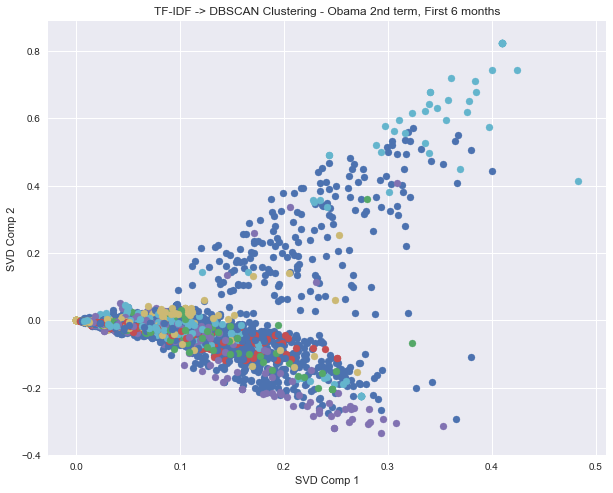

In [46]:
#plt.scatter(reduced_data[:,0],reduced_data[:,1])

df = pd.DataFrame(reduced_data)
df['label'] = dbs.labels_

fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches(10,8)

for d,df1 in df.groupby('label'):
    ax.scatter(df1[0],df1[1], label='label')
    
ax.set_title('TF-IDF -> DBSCAN Clustering - Obama 2nd term, First 6 months')
ax.set_xlabel('SVD Comp 1')
ax.set_ylabel('SVD Comp 2')



## Generate Word Clouds

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from os import path

In [164]:
def generateWordCloud(topicText, imageFilePath):
    alice_coloring = np.array(Image.open(imageFilePath))
    image_colors = ImageColorGenerator(alice_coloring)

    wordcloud = WordCloud(background_color="white", max_words=2000, 
                          stopwords=['change','report', 'action', 'may', 'yesterday', 'job', 'plan', 'decision'],
                          mask = alice_coloring).generate(topicText)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')
    ax.axis("off")
    fig.set_size_inches(12,10)

Generate word cloud in the shape of Donald Trump using topics that we derived out of Sean Spencer's White House press briefings

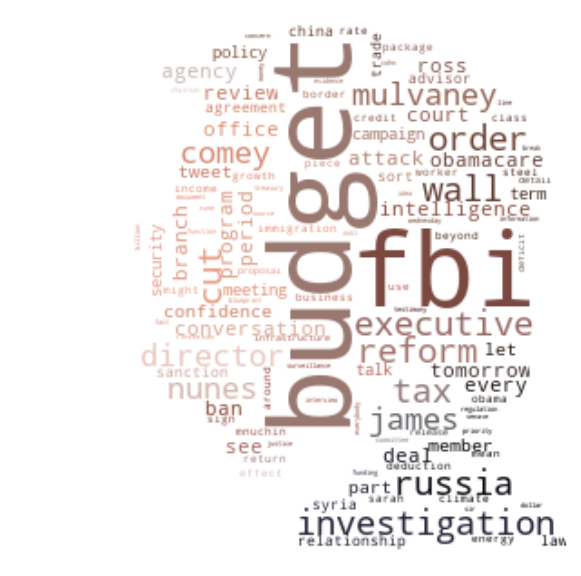

In [165]:
topicText = '''
order executive russia tax reform cut director mulvaney budget fbi james comey investigation nunes intelligence wall
part campaign policy security meeting may talk term budget russia yesterday change program report action relationship trade sort ross china job syria decision attack sanction agreement conversation advisor office deal

order executive court law immigration worker agency tomorrow change action review branch office obama see around sign climate ban every sarah steel piece effect might use mean energy beyond period

tax reform cut plan return mnuchin deduction income package growth obamacare credit class business border rate infrastructure detail release revenue proposal deficit wednesday priority job cohn break dollar concern regulation

director mulvaney budget fbi money confidence comey program blueprint agency james may let billion interview sir function senate testimony funding line debt name wall treasury investigation tweet fact everybody idea

information investigation nunes intelligence chairman committee member source yesterday tweet evidence document fbi surveillance justice congressman russian share conversation report staff branch community story claim trust allegation case let anyone

day every couple report event election plan action recommendation nafta news see finding ross review timeline ban decision period another attack guidance course travel confidence court role form sense three

bill healthcare plan vote pas wall obamacare legislation democrat republican price member topic senator change health conservative speaker ryan tomorrow without caucus condition care freedom act amendment deal floor congress
'''

generateWordCloud(topicText, 'trump.png')

Create word cloud in the shape of the American flag using words in the U.S. Constitution

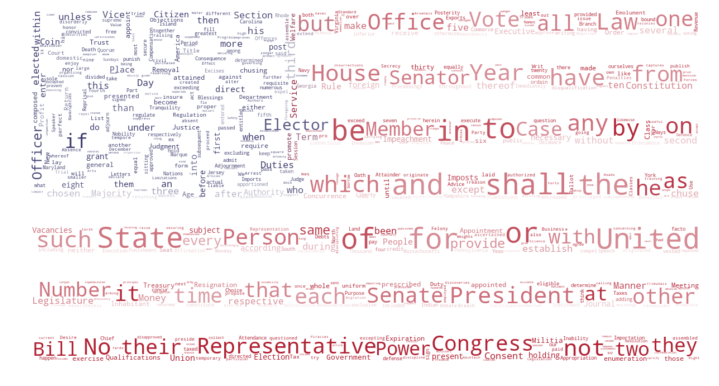

In [172]:
topicText = '''We the People of the United States, in Order to form a more perfect Union, establish Justice, insure domestic Tranquility, provide for the common defense, promote the general Welfare, and secure the Blessings of Liberty to ourselves and our Posterity, do ordain and establish this Constitution for the United States of America.
The House of Representatives shall be composed of Members chosen every second Year by the People of the several States, and the Electors in each State shall have the Qualifications requisite for Electors of the most numerous Branch of the State Legislature.
We the People of the United States, in Order to form a more perfect Union, establish Justice, insure domestic Tranquility, provide for the common defense, promote the general Welfare, and secure the Blessings of Liberty to ourselves and our Posterity, do ordain and establish this Constitution for the United States of America.
The House of Representatives shall be composed of Members chosen every second Year by the People of the several States, and the Electors in each State shall have the Qualifications requisite for Electors of the most numerous Branch of the State Legislature.
No Person shall be a Representative who shall not have attained to the Age of twenty five Years, and been seven Years a Citizen of the United States, and who shall not, when elected, be an Inhabitant of that State in which he shall be chosen.
Representatives and direct Taxes shall be apportioned among the several States which may be included within this Union, according to their respective Numbers, which shall be determined by adding to the whole Number of free Persons, including those bound to Service for a Term of Years, and excluding Indians not taxed, three fifths of all other Persons. The actual Enumeration shall be made within three Years after the first Meeting of the Congress of the United States, and within every subsequent Term of ten Years, in such Manner as they shall by Law direct. The Number of Representatives shall not exceed one for every thirty Thousand, but each State shall have at Least one Representative; and until such enumeration shall be made, the State of New Hampshire shall be entitled to chuse three, Massachusetts eight, Rhode-Island and Providence Plantations one, Connecticut five, New-York six, New Jersey four, Pennsylvania eight, Delaware one, Maryland six, Virginia ten, North Carolina five, South Carolina five, and Georgia three.
When vacancies happen in the Representation from any State, the Executive Authority thereof shall issue Writs of Election to fill such Vacancies.


The House of Representatives shall chuse their Speaker and other Officers; and shall have the sole Power of Impeachment.


Section 3 

The Senate of the United States shall be composed of two Senators from each State, chosen by the Legislature thereof, for six Years; and each Senator shall have one Vote.

Immediately after they shall be assembled in Consequence of the first Election, they shall be divided as equally as may be into three Classes. The Seats of the Senators of the first Class shall be vacated at the Expiration of the second Year, of the second Class at the Expiration of the fourth Year, and of the third Class at the Expiration of the sixth Year, so that one third may be chosen every second Year; and if Vacancies happen by Resignation, or otherwise, during the Recess of the Legislature of any State, the Executive thereof may make temporary Appointments until the next Meeting of the Legislature, which shall then fill such Vacancies.


No Person shall be a Senator who shall not have attained to the Age of thirty Years, and been nine Years a Citizen of the United States, and who shall not, when elected, be an Inhabitant of that State for which he shall be chosen.


The Vice President of the United States shall be President of the Senate, but shall have no Vote, unless they be equally divided.


The Senate shall chuse their other Officers, and also a President pro tempore, in the Absence of the Vice President, or when he shall exercise the Office of President of the United States.


The Senate shall have the sole Power to try all Impeachments. When sitting for that Purpose, they shall be on Oath or Affirmation. When the President of the United States is tried, the Chief Justice shall preside: And no Person shall be convicted without the Concurrence of two thirds of the Members present.

Judgment in Cases of Impeachment shall not extend further than to removal from Office, and disqualification to hold and enjoy any Office of honor, Trust or Profit under the United States: but the Party convicted shall nevertheless be liable and subject to Indictment, Trial, Judgment and Punishment, according to Law.


Section 4 
The Times, Places and Manner of holding Elections for Senators and Representatives, shall be prescribed in each State by the Legislature thereof; but the Congress may at any time by Law make or alter such Regulations, except as to the Places of chusing Senators.

The Congress shall assemble at least once in every Year, and such Meeting shall be on the first Monday in December, unless they shall by Law appoint a different Day.


Section 5 

Each House shall be the Judge of the Elections, Returns and Qualifications of its own Members, and a Majority of each shall constitute a Quorum to do Business; but a smaller Number may adjourn from day to day, and may be authorized to compel the Attendance of absent Members, in such Manner, and under such Penalties as each House may provide.

Each House may determine the Rules of its Proceedings, punish its Members for disorderly Behaviour, and, with the Concurrence of two thirds, expel a Member.


Each House shall keep a Journal of its Proceedings, and from time to time publish the same, excepting such Parts as may in their Judgment require Secrecy; and the Yeas and Nays of the Members of either House on any question shall, at the Desire of one fifth of those Present, be entered on the Journal.


Neither House, during the Session of Congress, shall, without the Consent of the other, adjourn for more than three days, nor to any other Place than that in which the two Houses shall be sitting.


Section 6 

The Senators and Representatives shall receive a Compensation for their Services, to be ascertained by Law, and paid out of the Treasury of the United States. They shall in all Cases, except Treason, Felony and Breach of the Peace, be privileged from Arrest during their Attendance at the Session of their respective Houses, and in going to and returning from the same; and for any Speech or Debate in either House, they shall not be questioned in any other Place.


No Senator or Representative shall, during the Time for which he was elected, be appointed to any civil Office under the Authority of the United States, which shall have been created, or the Emoluments whereof shall have been encreased during such time; and no Person holding any Office under the United States, shall be a Member of either House during his Continuance in Office.

 


Section 7 

All Bills for raising Revenue shall originate in the House of Representatives; but the Senate may propose or concur with Amendments as on other Bills.


Every Bill which shall have passed the House of Representatives and the Senate, shall, before it become a Law, be presented to the President of the United States: If he approve he shall sign it, but if not he shall return it, with his Objections to that House in which it shall have originated, who shall enter the Objections at large on their Journal, and proceed to reconsider it.  If after such Reconsideration two thirds of that House shall agree to pass the Bill, it shall be sent, together with the Objections, to the other House, by which it shall likewise be reconsidered, and if approved by two thirds of that House, it shall become a Law. But in all such Cases the Votes of both Houses shall be determined by Yeas and Nays, and the Names of the Persons voting for and against the Bill shall be entered on the Journal of each House respectively. If any Bill shall not be returned by the President within ten Days (Sundays excepted) after it shall have been presented to him, the Same shall be a Law, in like Manner as if he had signed it, unless the Congress by their Adjournment prevent its Return, in which Case it shall not be a Law.

Every Order, Resolution, or Vote to which the Concurrence of the Senate and House of Representatives may be necessary (except on a question of Adjournment) shall be presented to the President of the United States; and before the Same shall take Effect, shall be approved by him, or being disapproved by him, shall be repassed by two thirds of the Senate and House of Representatives, according to the Rules and Limitations prescribed in the Case of a Bill.


Section 8 

The Congress shall have Power To lay and collect Taxes, Duties, Imposts and Excises, to pay the Debts and provide for the common Defence and general Welfare of the United States; but all Duties, Imposts and Excises shall be uniform throughout the United States;


To borrow Money on the credit of the United States;


To regulate Commerce with foreign Nations, and among the several States, and with the Indian Tribes;


To establish an uniform Rule of Naturalization, and uniform Laws on the subject of Bankruptcies throughout the United States;


To coin Money, regulate the Value thereof, and of foreign Coin, and fix the Standard of Weights and Measures;

To provide for the Punishment of counterfeiting the Securities and current Coin of the United States;


To establish Post Offices and post Roads;

 


To promote the Progress of Science and useful Arts, by securing for limited Times to Authors and Inventors the exclusive Right to their respective Writings and Discoveries;


To constitute Tribunals inferior to the supreme Court;


To define and punish Piracies and Felonies committed on the high Seas, and Offences against the Law of Nations;


To declare War, grant Letters of Marque and Reprisal, and make Rules concerning Captures on Land and Water;

To raise and support Armies, but no Appropriation of Money to that Use shall be for a longer Term than two Years;
To provide and maintain a Navy;
To make Rules for the Government and Regulation of the land and naval Forces;
To provide for calling forth the Militia to execute the Laws of the Union, suppress Insurrections and repel Invasions;
To provide for organizing, arming, and disciplining, the Militia, and for governing such Part of them as may be employed in the Service of the United States, reserving to the States respectively, the Appointment of the Officers, and the Authority of training the Militia according to the discipline prescribed by Congress;
To exercise exclusive Legislation in all Cases whatsoever, over such District (not exceeding ten Miles square) as may, by Cession of particular States, and the Acceptance of Congress, become the Seat of the Government of the United States, and to exercise like Authority over all Places purchased by the Consent of the Legislature of the State in which the Same shall be, for the Erection of Forts, Magazines, Arsenals, dock-Yards, and other needful Buildings;—And
To make all Laws which shall be necessary and proper for carrying into Execution the foregoing Powers, and all other Powers vested by this Constitution in the Government of the United States, or in any Department or Officer thereof.
The Migration or Importation of such Persons as any of the States now existing shall think proper to admit, shall not be prohibited by the Congress prior to the Year one thousand eight hundred and eight, but a Tax or duty may be imposed on such Importation, not exceeding ten dollars for each Person.
The Privilege of the Writ of Habeas Corpus shall not be suspended, unless when in Cases of Rebellion or Invasion the public Safety may require it.
No Bill of Attainder or ex post facto Law shall be passed.
No Capitation, or other direct, Tax shall be laid, unless in Proportion to the Census or enumeration herein before directed to be taken.
No Tax or Duty shall be laid on Articles exported from any State.
No Preference shall be given by any Regulation of Commerce or Revenue to the Ports of one State over those of another; nor shall Vessels bound to, or from, one State, be obliged to enter, clear, or pay Duties in another.
No Money shall be drawn from the Treasury, but in Consequence of Appropriations made by Law; and a regular Statement and Account of the Receipts and Expenditures of all public Money shall be published from time to time.
No Title of Nobility shall be granted by the United States: And no Person holding any Office of Profit or Trust under them, shall, without the Consent of the Congress, accept of any present, Emolument, Office, or Title, of any kind whatever, from any King, Prince, or foreign State.
No State shall enter into any Treaty, Alliance, or Confederation; grant Letters of Marque and Reprisal; coin Money; emit Bills of Credit; make any Thing but gold and silver Coin a Tender in Payment of Debts; pass any Bill of Attainder, ex post facto Law, or Law impairing the Obligation of Contracts, or grant any Title of Nobility.
No State shall, without the Consent of the Congress, lay any Imposts or Duties on Imports or Exports, except what may be absolutely necessary for executing its inspection Laws: and the net Produce of all Duties and Imposts, laid by any State on Imports or Exports, shall be for the Use of the Treasury of the United States; and all such Laws shall be subject to the Revision and Control of the Congress.
No State shall, without the Consent of Congress, lay any Duty of Tonnage, keep Troops, or Ships of War in time of Peace, enter into any Agreement or Compact with another State, or with a foreign Power, or engage in War, unless actually invaded, or in such imminent Danger as will not admit of delay.
The executive Power shall be vested in a President of the United States of America. He shall hold his Office during the Term of four Years, and, together with the Vice President, chosen for the same Term, be elected, as follows:
Each State shall appoint, in such Manner as the Legislature thereof may direct, a Number of Electors, equal to the whole Number of Senators and Representatives to which the State may be entitled in the Congress: but no Senator or Representative, or Person holding an Office of Trust or Profit under the United States, shall be appointed an Elector.
The Electors shall meet in their respective States, and vote by Ballot for two Persons, of whom one at least shall not be an Inhabitant of the same State with themselves. And they shall make a List of all the Persons voted for, and of the Number of Votes for each; which List they shall sign and certify, and transmit sealed to the Seat of the Government of the United States, directed to the President of the Senate. The President of the Senate shall, in the Presence of the Senate and House of Representatives, open all the Certificates, and the Votes shall then be counted. The Person having the greatest Number of Votes shall be the President, if such Number be a Majority of the whole Number of Electors appointed; and if there be more than one who have such Majority, and have an equal Number of Votes, then the House of Representatives shall immediately chuse by Ballot one of them for President; and if no Person have a Majority, then from the five highest on the List the said House shall in like Manner chuse the President. But in chusing the President, the Votes shall be taken by States, the Representatives from each State having one Vote; a quorum for this Purpose shall consist of a Member or Members from two thirds of the States, and a Majority of all the States shall be necessary to a Choice. In every Case, after the Choice of the President, the Person having the greatest Number of Votes of the Electors shall be the Vice President. But if there should remain two or more who have equal Votes, the Senate shall chuse from them by Ballot the Vice-President.
The Congress may determine the Time of chusing the Electors, and the Day on which they shall give their Votes; which Day shall be the same throughout the United States.
No Person except a natural born Citizen, or a Citizen of the United States, at the time of the Adoption of this Constitution, shall be eligible to the Office of President; neither shall any person be eligible to that Office who shall not have attained to the Age of thirty five Years, and been fourteen Years a Resident within the United States.
In Case of the Removal of the President from Office, or of his Death, Resignation, or Inability to discharge the Powers and Duties of the said Office, the Same shall devolve on the Vice President, and the Congress may by Law provide for the Case of Removal, Death, Resignation or Inability, both of the President and Vice President, declaring what Officer shall then act as President, and such Officer shall act accordingly, until the Disability be removed, or a President shall be elected.
The President shall, at stated Times, receive for his Services, a Compensation, which shall neither be encreased nor diminished during the Period for which he shall have been elected, and he shall not receive within that Period any other Emolument from the United States, or any of them.
Before he enter on the Execution of his Office, he shall take the following Oath or Affirmation:—"I do solemnly swear (or affirm) that I will faithfully execute the Office of President of the United States, and will to the best of my Ability, preserve, protect and defend the Constitution of the United States."
The President shall be Commander in Chief of the Army and Navy of the United States, and of the Militia of the several States, when called into the actual Service of the United States; he may require the Opinion, in writing, of the principal Officer in each of the executive Departments, upon any Subject relating to the Duties of their respective Offices, and he shall have Power to Grant Reprieves and Pardons for Offences against the United States, except in Cases of Impeachment.
He shall have Power, by and with the Advice and Consent of the Senate, to make Treaties, provided two thirds of the Senators present concur; and he shall nominate, and by and with the Advice and Consent of the Senate, shall appoint Ambassadors, other public Ministers and Consuls, Judges of the supreme Court, and all other Officers of the United States, whose Appointments are not herein otherwise provided for, and which shall be established by Law: but the Congress may by Law vest the Appointment of such inferior Officers, as they think proper, in the President alone, in the Courts of Law, or in the Heads of Departments.'''

generateWordCloud(topicText, 'american-flag-large.png')

## Sentiment Analysis

In [ ]:
from textblob import TextBlob

In [131]:
sentimentByDate = answersDataSet.groupby('dateTime', group_keys=False).paragraph.apply(lambda x: TextBlob(' '.join(x)).sentiment).reset_index()

In [132]:
sentimentByDate['polarity'] = sentimentByDate.paragraph.apply(lambda x: x[0])
sentimentByDate['subjectivity'] = sentimentByDate.paragraph.apply(lambda x: x[1])

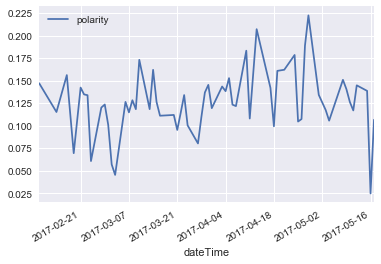

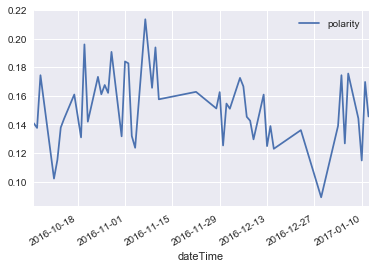

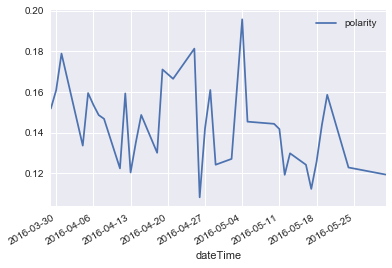

In [133]:
sentimentByDate.iloc[-60:].plot(y='polarity', x='dateTime')
sentimentByDate.iloc[-120:-70].plot(y='polarity', x='dateTime')
sentimentByDate.iloc[-220:-185].plot(y='polarity', x='dateTime')

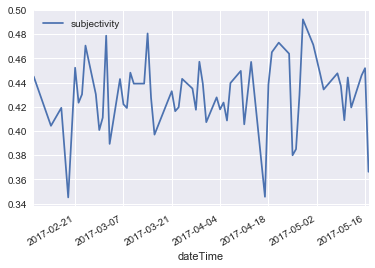

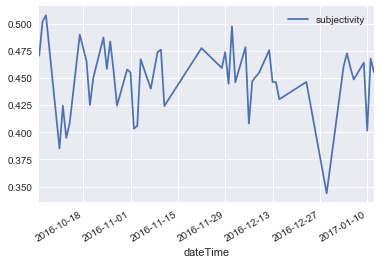

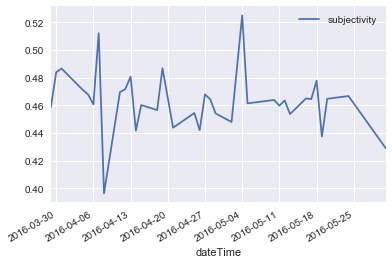

In [134]:
sentimentByDate.plot(y='subjectivity', x='dateTime')
sentimentByDate.iloc[-120:-70].plot(y='subjectivity', x='dateTime')
sentimentByDate.iloc[-220:-185].plot(y='subjectivity', x='dateTime')

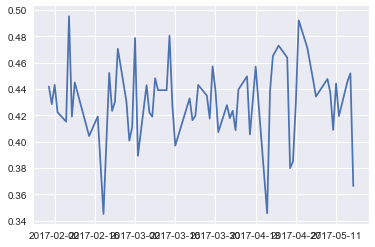

In [156]:
df = sentimentByDate[(sentimentByDate.dateTime > '2017-01-21') & (sentimentByDate.dateTime < '2017-06-30')]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(df.dateTime, df.subjectivity)

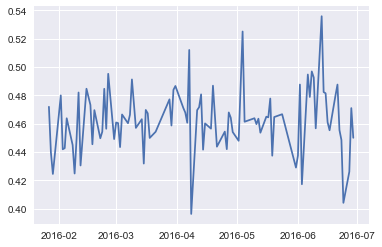

In [157]:
df = sentimentByDate[(sentimentByDate.dateTime > '2016-01-21') & (sentimentByDate.dateTime < '2016-06-30')]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(df.dateTime, df.subjectivity)

In [ ]:
ques